In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import datetime
from dateutil.parser import parse
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from string import punctuation
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sentiment
from sklearn import manifold
import matplotlib.pyplot as plt
import en_core_web_lg

## Data Cleaning

In [3]:
df = pd.read_csv('booksdata.csv')
# df.shape

In [4]:
df = df.drop("web-scraper-order",axis=1)
df = df.drop("web-scraper-start-url",axis=1)
df = df.drop("bookreview_user",axis=1)
df = df.drop("books-href",axis=1)

df.bookreview_2.fillna(df.bookreview_1, inplace=True)
df = df.drop("bookreview_1",axis=1)

In [5]:
def remove_punctuations(item):
    for p in punctuation:
        item = item.strip().replace(p,'')
    return item

def remove_stopwords(s):
    return [w for w in s if not w in stop_words] 

stop_words = set(stopwords.words('english')) 

In [6]:
df.rename(columns = {'booktitle':'Title','bookauthor':'Author','booksummary':'Summary','booklength':'Length','books':'Book_ID','bookgenre':'Genre','bookavgrating':'Overall_Rating','bookratingcount':'Rating_Count','bookcover-src':'Cover_URL','publishdate':'Publish_Date','bookreviewcount':'Review_Count','bookreview_rating':'User_Rating','bookreview_2':'User_Review'}, inplace = True)
df['Author_ID'] = df['Author']
lb_make = LabelEncoder()
df['Author_ID'] = lb_make.fit_transform(df['Author_ID'])
df['Length'] = df['Length'].str.replace("pages","")
df[['Length']] = df[['Length']].astype(float)
today = datetime.date.today()
df['Publish_Date'] = df['Publish_Date'].apply(lambda x: x.split('\n')[1].replace('th','').replace('rd','').replace('nd','').strip())
df['Publish_Days'] = df['Publish_Date'].apply(lambda x: int((today - parse(x).date()).days ))
df['Rating_Count'] = df['Rating_Count'].apply(lambda x: int(x.split('\n')[0].strip().replace(',','')))
df['Review_Count'] = df['Review_Count'].apply(lambda x: int(x.split('\n')[0].strip().replace(',','')))
df['Genre'] = df['Genre'].apply(lambda x: x.replace('[{"bookgenre":','')) \
                    .apply(lambda x: x.replace('{"bookgenre":','')) \
                    .apply(lambda x: x.replace('}','')) \
                    .apply(lambda x: x.replace(']','')) \
                    .apply(lambda x: x.replace('"','')) \
                    .apply(lambda x: x.replace(',',' '))
df["Summary_Length"]= df["Summary"].str.len() 
df["Review_Length"]= df["User_Review"].str.len() 
df["Summary"] = df['Summary'].apply(remove_punctuations) \
                             .apply(lambda x: x.lower())
df['Summary'].replace({'men': 'man','killer': 'murder','women': 'woman', 'american':'america','united':'america','states':'america','americas':'america','donald':'trump','presidency':'president', 'presidential':'president'}, inplace=True, regex=True)
# df['Summary_Tokens'] = df['Summary'].apply(word_tokenize).apply(set).apply(list)
# df['Summary_Tokens'] = df['Summary_Tokens'].apply(remove_stopwords)
df[['User_Review']] = df[['User_Review']].astype(str)
df["User_Review"] = df['User_Review'].apply(remove_punctuations) \
                                     .apply(lambda x: x.lower())
df['User_Review'].replace({'donald': 'trump','characters': 'character','felt':'feel','american':'america','united':'america','states':'america','americas':'america'},inplace=True, regex=True)
# df['Review_Tokens'] = df['User_Review'].apply(word_tokenize).apply(set).apply(list)
# df['Review_Tokens'] = df['Review_Tokens'].apply(remove_stopwords)
df[['User_Rating']] = df[['User_Rating']].astype(str)
df['User_Rating'] = df['User_Rating'].apply(lambda x: x.replace('did not like it','1')) \
                    .apply(lambda x: x.replace('it was ok','2')) \
                    .apply(lambda x: x.replace('really liked it','4')) \
                    .apply(lambda x: x.replace('liked it','3')) \
                    .apply(lambda x: x.replace('it was amazing','5')) 
df = df[['Book_ID','Title','Author_ID','Author','Length','Publish_Date','Publish_Days','Cover_URL','Overall_Rating','Rating_Count','Review_Count','Genre','Summary','Summary_Length','User_Rating','User_Review','Review_Length']]
df = df.sort_values(['Book_ID','Author_ID'])
df.head(5)

,Book_ID,Title,Author_ID,Author,Length,Publish_Date,Publish_Days,Cover_URL,Overall_Rating,Rating_Count,Review_Count,Genre,Summary,Summary_Length,User_Rating,User_Review,Review_Length
385,1,The Guardians,42,John Grisham,375.0,October 15 2019,51,https://i.gr-assets.com/images/S/compressed.ph...,4.27,13106,1182,Fiction Mystery Thriller Thriller Legal Thriller,in the small north florida town of seabrook a ...,1424,5,what a great legal thriller john grisham has l...,444.0
531,1,The Guardians,42,John Grisham,375.0,October 15 2019,51,https://i.gr-assets.com/images/S/compressed.ph...,4.27,13106,1182,Fiction Mystery Thriller Thriller Legal Thriller,in the small north florida town of seabrook a ...,1424,5,loved this book again i’m not disappointed one...,61.0
540,1,The Guardians,42,John Grisham,375.0,October 15 2019,51,https://i.gr-assets.com/images/S/compressed.ph...,4.27,13106,1182,Fiction Mystery Thriller Thriller Legal Thriller,in the small north florida town of seabrook a ...,1424,5,a deftly written and thoughtprovoking book tha...,3093.0
546,1,The Guardians,42,John Grisham,375.0,October 15 2019,51,https://i.gr-assets.com/images/S/compressed.ph...,4.27,13106,1182,Fiction Mystery Thriller Thriller Legal Thriller,in the small north florida town of seabrook a ...,1424,5,no stranger than the truth\n\nbased on the tru...,289.0
641,1,The Guardians,42,John Grisham,375.0,October 15 2019,51,https://i.gr-assets.com/images/S/compressed.ph...,4.27,13106,1182,Fiction Mystery Thriller Thriller Legal Thriller,in the small north florida town of seabrook a ...,1424,3,the guardians • john grisham • started finish...,1811.0


In [7]:
df.to_csv('Clean_Reviews.csv')

In [8]:
df=pd.read_csv('Clean_Reviews.csv')
df['Summary_Tokens'] = df['Summary'].apply(word_tokenize).apply(set).apply(list)
df['Summary_Tokens'] = df['Summary_Tokens'].apply(remove_stopwords)
df[['User_Review']] = df[['User_Review']].astype(str)
df['Review_Tokens'] = df['User_Review'].apply(word_tokenize).apply(set).apply(list)
df['Review_Tokens'] = df['Review_Tokens'].apply(remove_stopwords)

## Task 1

## Count word frequency - Fiction vs Non-Fiction

In [9]:
## Summary - Fiction
count = []
# Count the frequency of the words

for i in range(50):
    count += df[df["Book_ID"]< 51].drop_duplicates(subset="Book_ID")["Summary_Tokens"].iloc[i]
    
count = [x.lower() for x in count]
word_freq = nltk.FreqDist(count)

# 100 most frequent words
top_words = word_freq.most_common(100)
top_words

[('new', 31),
 ('one', 25),
 ('’', 21),
 ('times', 21),
 ('york', 21),
 ('man', 18),
 ('time', 18),
 ('1', 18),
 ('world', 17),
 ('bestselling', 17),
 ('woman', 16),
 ('murder', 15),
 ('never', 15),
 ('novel', 14),
 ('young', 13),
 ('life', 13),
 ('home', 13),
 ('story', 13),
 ('family', 13),
 ('author', 13),
 ('two', 11),
 ('next', 11),
 ('first', 11),
 ('left', 10),
 ('begins', 10),
 ('ever', 10),
 ('help', 10),
 ('back', 10),
 ('find', 10),
 ('finds', 10),
 ('something', 10),
 ('town', 9),
 ('another', 9),
 ('years', 9),
 ('comes', 9),
 ('crime', 9),
 ('becomes', 9),
 ('three', 9),
 ('may', 9),
 ('could', 9),
 ('night', 8),
 ('even', 8),
 ('war', 8),
 ('death', 8),
 ('desperate', 8),
 ('place', 8),
 ('like', 8),
 ('house', 8),
 ('make', 8),
 ('lives', 8),
 ('series', 8),
 ('thriller', 8),
 ('former', 8),
 ('must', 8),
 ('father', 8),
 ('day', 8),
 ('behind', 7),
 ('outside', 7),
 ('far', 7),
 ('soon', 7),
 ('police', 7),
 ('become', 7),
 ('beautiful', 7),
 ('mother', 7),
 ('takes', 

In [10]:
## Summary - Fiction
count = []
# Count the frequency of the words

for i in range(50):
    count += df[df["Book_ID"]>50].drop_duplicates(subset="Book_ID")["Summary_Tokens"].iloc[i]
    
count = [x.lower() for x in count]
word_freq = nltk.FreqDist(count)

# 100 most frequent words
top_words = word_freq.most_common(100)
top_words

[('america', 31),
 ('new', 25),
 ('book', 24),
 ('’', 24),
 ('president', 23),
 ('first', 23),
 ('life', 22),
 ('one', 22),
 ('us', 20),
 ('world', 20),
 ('trump', 19),
 ('story', 19),
 ('time', 19),
 ('history', 19),
 ('personal', 15),
 ('like', 14),
 ('people', 14),
 ('york', 13),
 ('times', 13),
 ('way', 13),
 ('political', 13),
 ('2016', 12),
 ('“', 12),
 ('many', 12),
 ('”', 12),
 ('author', 12),
 ('never', 12),
 ('years', 12),
 ('comes', 11),
 ('account', 11),
 ('election', 11),
 ('shows', 11),
 ('work', 11),
 ('also', 11),
 ('public', 11),
 ('even', 11),
 ('1', 11),
 ('woman', 10),
 ('tells', 10),
 ('man', 10),
 ('including', 10),
 ('politics', 10),
 ('war', 10),
 ('would', 10),
 ('country', 10),
 ('written', 10),
 ('deeply', 9),
 ('administration', 9),
 ('back', 9),
 ('make', 9),
 ('star', 9),
 ('past', 9),
 ('governmant', 9),
 ('memoir', 9),
 ('take', 9),
 ('campaign', 9),
 ('obama', 9),
 ('offers', 8),
 ('office', 8),
 ('great', 8),
 ('democracy', 8),
 ('human', 8),
 ('nation

In [11]:
df_test = df[df["Book_ID"]<51]
## Review - Fiction
count = []

# Count the frequency of the words
for i in range(len(df_test)):
    count += df_test['Review_Tokens'].iloc[i]

count = [x.lower() for x in count]
word_freq = nltk.FreqDist(count)

# 100 most frequent words
top_words = word_freq.most_common(100)
top_words

[('book', 9928),
 ('one', 7764),
 ('read', 7676),
 ('story', 6569),
 ('character', 6450),
 ('like', 5537),
 ('books', 4716),
 ('’', 4547),
 ('time', 4195),
 ('really', 4045),
 ('good', 4026),
 ('series', 3903),
 ('much', 3901),
 ('would', 3663),
 ('first', 3539),
 ('love', 3536),
 ('get', 3376),
 ('reading', 3339),
 ('also', 3290),
 ('feel', 3224),
 ('well', 3223),
 ('even', 3200),
 ('way', 3139),
 ('know', 3029),
 ('great', 2991),
 ('novel', 2962),
 ('many', 2854),
 ('end', 2847),
 ('another', 2746),
 ('new', 2735),
 ('think', 2703),
 ('still', 2688),
 ('people', 2599),
 ('could', 2581),
 ('plot', 2569),
 ('always', 2557),
 ('life', 2532),
 ('see', 2454),
 ('two', 2425),
 ('back', 2422),
 ('going', 2416),
 ('little', 2396),
 ('never', 2331),
 ('stars', 2257),
 ('writing', 2235),
 ('make', 2205),
 ('author', 2171),
 ('loved', 2167),
 ('next', 2163),
 ('enjoyed', 2154),
 ('find', 2072),
 ('say', 2054),
 ('things', 1999),
 ('bit', 1991),
 ('last', 1972),
 ('found', 1955),
 ('interesting'

In [12]:
df_test = df[df["Book_ID"]>50]
## Review - Fiction
count = []

# Count the frequency of the words
for i in range(len(df_test)):
    count += df_test['Review_Tokens'].iloc[i]

count = [x.lower() for x in count]
word_freq = nltk.FreqDist(count)

# 100 most frequent words
top_words = word_freq.most_common(100)
top_words

[('book', 10459),
 ('read', 6773),
 ('one', 4878),
 ('like', 4718),
 ('would', 3888),
 ('much', 3806),
 ('’', 3786),
 ('people', 3734),
 ('also', 3384),
 ('many', 3362),
 ('time', 3354),
 ('really', 3197),
 ('reading', 3163),
 ('well', 3160),
 ('good', 3135),
 ('america', 3099),
 ('even', 3096),
 ('life', 3093),
 ('trump', 2884),
 ('us', 2840),
 ('way', 2840),
 ('think', 2840),
 ('great', 2732),
 ('know', 2730),
 ('get', 2614),
 ('first', 2542),
 ('history', 2482),
 ('feel', 2417),
 ('could', 2412),
 ('interesting', 2333),
 ('story', 2318),
 ('made', 2310),
 ('president', 2216),
 ('make', 2158),
 ('years', 2138),
 ('things', 2137),
 ('books', 2136),
 ('still', 2131),
 ('never', 2101),
 ('lot', 2097),
 ('political', 2036),
 ('world', 2008),
 ('new', 1946),
 ('see', 1868),
 ('work', 1851),
 ('love', 1835),
 ('better', 1823),
 ('say', 1801),
 ('times', 1752),
 ('found', 1752),
 ('dont', 1751),
 ('written', 1737),
 ('”', 1708),
 ('“', 1699),
 ('little', 1698),
 ('always', 1677),
 ('thought

In [13]:
top_fiction_summary_words_count = [('man',18),('world',17),('bestselling',17),('woman',16),('murder',15),('life',13),('story',13),('home',13),('author',13),('family',13),('young',13),('help',10),('town',9),('crime',9),('series',8),('night',8),('like',8),('war',8),('desperate',8),('death',8),('house',8),('thriller',8),('mother',7),('father',8),('day',8),('police',7),('beautiful',7),('investigation',7),('truth',7)]
top_nonfiction_summary_words_count = [('america',31),('life',22),('president',23),('world',20),('story',19),('history',19),('trump',19),('personal',15),('like',14),('people',14),('political',13),('2016',12),('author',12),('election',11),('work',11),('public',11),('man',10),('woman',10),('country',10),('war',10),('administration',9),('campaign',9),('obama',9),('office',8),('human',8),('democracy',8),('great',8),('nation',8),('bestselling',8),('house',8),('news',8),('clinton',7)]

top_fiction_review_words_count = [('story',6569),('character',6450),('like',5537),('series',3903),('love',3536),('great',2991), ('end',2847),('new',2735),('think',2703),('people',2599),('plot',2569),('life',2532),('stars',2577),('author',2171),('enjoyed',2154),('loved',2167),('interesting',1938),('world',1808),('murder',1807),('family',1758),('man',1725),('different',1702)]
top_nonfiction_review_words_count = [('people',3734),('time',3354),('life',3093),('trump',2884),('think',2840),('great',2732),('history',2482),('interesting',2333),('story',2318),('president',2216),('political',2036),('world',2008),('work',1851),('love',1835),('america',3099),('right',1638),('country',1557),('man',1416),('politics',1407),('author',1406),('white',1376),('personal',1373)]


### Lift Analysis of Summary of Fictional Books

In [14]:
# Lift ratios for Top words in Fiction book summary
top_fiction_summary_words =[]
for word, count in top_fiction_summary_words_count:
    top_fiction_summary_words.append(word) 

word_df = pd.DataFrame(columns = top_fiction_summary_words)

def word_count(item):
    if checker in item:
        return 1
    else:
        return 0

for word in top_fiction_summary_words:
    checker = word
    word_df[word] = df[df["Book_ID"]<51]['Summary'].drop_duplicates().apply(word_count)       

lift_df_fic_sum = pd.DataFrame(columns = top_fiction_summary_words)

for i in range(len(top_fiction_summary_words)):
    new_list = []
    for j in range(len(top_fiction_summary_words)):
        if (i!=j):
            num = ((word_df[top_fiction_summary_words[i]] + word_df[top_fiction_summary_words[j]]) > 1).sum()
            dem = word_df[top_fiction_summary_words[j]].sum()*word_df[top_fiction_summary_words[i]].sum()
            lift = num * len(word_df) / dem
            lift_df_fic_sum.loc[top_fiction_summary_words[i],top_fiction_summary_words[j]] = lift
#             if lift>2:
#                 print(top_fiction_summary_words[i],top_fiction_summary_words[j])

print ('Lift Matrix:\n')
lift_df_fic_sum

Lift Matrix:



,man,world,bestselling,woman,murder,life,story,home,author,family,...,death,house,thriller,mother,father,day,police,beautiful,investigation,truth
man,NaN,1.05263,0.935673,1.11111,1.04575,1.03704,1.03704,1.04575,1.03175,1.02564,...,1.11111,0.987654,0.864198,0.987654,0.833333,0.873016,1.11111,1.11111,0.833333,1.11111
world,1.05263,NaN,0.831025,0.773994,0.773994,0.877193,1.40351,0.773994,0.56391,1.21457,...,1.16959,1.16959,0.292398,1.16959,0.986842,0.75188,0.75188,1.50376,0.328947,0
bestselling,0.935673,0.831025,NaN,0.309598,0.928793,0.701754,0.526316,0.619195,2.06767,1.417,...,0.877193,1.46199,1.75439,0.584795,0.657895,1.12782,1.12782,0.37594,1.31579,0.75188
woman,1.11111,0.773994,0.309598,NaN,1.03806,1.17647,1.17647,1.21107,0.630252,0.452489,...,0.326797,0.653595,0.653595,1.63399,0.735294,1.05042,1.2605,1.2605,1.10294,1.2605
murder,1.04575,0.773994,0.928793,1.03806,NaN,0.588235,0.784314,1.03806,0.840336,0.452489,...,0.980392,0.653595,0.980392,0.653595,1.10294,0.420168,2.10084,0.420168,1.47059,1.2605
life,1.03704,0.877193,0.701754,1.17647,0.588235,NaN,1.33333,0.980392,1.19048,1.02564,...,1.11111,1.11111,0.37037,1.85185,0.416667,1.42857,1.42857,1.42857,0.833333,0.952381
story,1.03704,1.40351,0.526316,1.17647,0.784314,1.33333,NaN,0.588235,0.952381,1.28205,...,1.11111,1.48148,0,1.48148,1.25,1.66667,0.47619,2.38095,0.833333,0.952381
home,1.04575,0.773994,0.619195,1.21107,1.03806,0.980392,0.588235,NaN,0.210084,1.58371,...,0.980392,0.980392,1.30719,1.63399,1.10294,1.05042,0.420168,1.68067,0.735294,2.10084
author,1.03175,0.56391,2.06767,0.630252,0.840336,1.19048,0.952381,0.210084,NaN,1.0989,...,1.19048,1.98413,1.5873,0.793651,0.892857,1.27551,1.02041,0.510204,1.33929,0.510204
family,1.02564,1.21457,1.417,0.452489,0.452489,1.02564,1.28205,1.58371,1.0989,NaN,...,2.13675,1.7094,1.28205,2.5641,1.92308,1.0989,0.549451,0.549451,0,1.64835


### Lift Analysis of Reviews of Fictional Books

In [15]:
# Lift ratios for Top words in Fiction book summary
top_fiction_review_words =[]
for word, count in top_fiction_review_words_count:
    top_fiction_review_words.append(word) 

word_df = pd.DataFrame(columns = top_fiction_review_words)

def word_count(item):
    if checker in item:
        return 1
    else:
        return 0

for word in top_fiction_review_words:
    checker = word
    word_df[word] = df[df["Book_ID"]<51]['User_Review'].apply(word_count)       

lift_df_fic_rev = pd.DataFrame(columns = top_fiction_review_words)

for i in range(len(top_fiction_review_words)):
    new_list = []
    for j in range(len(top_fiction_review_words)):
        if (i!=j):
            num = ((word_df[top_fiction_review_words[i]] + word_df[top_fiction_review_words[j]]) > 1).sum()
            dem = word_df[top_fiction_review_words[j]].sum()*word_df[top_fiction_review_words[i]].sum()
            lift = num * len(word_df) / dem
            lift_df_fic_rev.loc[top_fiction_review_words[i],top_fiction_review_words[j]] = lift
#             if lift >2:
#                 print(top_fiction_review_words[i],top_fiction_review_words[j])

print ('Lift Matrix:\n')
lift_df_fic_rev

Lift Matrix:



,story,character,like,series,love,great,end,new,think,people,...,stars,author,enjoyed,loved,interesting,world,murder,family,man,different
story,NaN,1.31847,1.2824,1.0533,1.25169,1.30983,1.26095,1.31048,1.39352,1.38312,...,1.28635,1.34642,1.26922,1.30061,1.41556,1.52295,1.14471,1.49429,1.30801,1.51276
character,1.31847,NaN,1.35739,1.30176,1.33737,1.33318,1.29677,1.4055,1.43311,1.37179,...,1.31046,1.48004,1.32331,1.37063,1.57326,1.47614,1.27193,1.40435,1.36135,1.56116
like,1.2824,1.35739,NaN,1.2169,1.24789,1.2869,1.31545,1.39631,1.57075,1.53045,...,1.37122,1.4326,1.26288,1.28156,1.39741,1.5205,1.18659,1.39387,1.3641,1.57154
series,1.0533,1.30176,1.2169,NaN,1.20165,1.12666,1.16143,1.481,1.23514,1.19206,...,0.998664,1.19549,1.103,0.966802,1.33369,1.2791,1.65585,1.23543,1.27332,1.26961
love,1.25169,1.33737,1.24789,1.20165,NaN,1.33218,1.28063,1.34157,1.41431,1.4419,...,1.34131,1.30791,1.08756,3.09625,1.07951,1.5418,1.14113,1.63432,1.31869,1.48453
great,1.30983,1.33318,1.2869,1.12666,1.33218,NaN,1.26953,1.34643,1.45733,1.33186,...,1.23249,1.31956,1.18073,1.43663,1.32062,1.70333,1.1572,1.46647,1.29709,1.47364
end,1.26095,1.29677,1.31545,1.16143,1.28063,1.26953,NaN,1.41641,1.41723,1.44325,...,1.33817,1.43112,1.24172,1.34416,1.32671,1.47905,1.34447,1.55402,1.39341,1.48867
new,1.31048,1.4055,1.39631,1.481,1.34157,1.34643,1.41641,NaN,1.57276,1.59449,...,1.25193,1.57386,1.19627,1.38451,1.48507,1.83469,1.50812,1.86075,1.56207,1.69617
think,1.39352,1.43311,1.57075,1.23514,1.41431,1.45733,1.41723,1.57276,NaN,1.88106,...,1.51307,1.59421,1.3387,1.4988,1.54555,1.83854,1.27426,1.55834,1.52884,1.7835
people,1.38312,1.37179,1.53045,1.19206,1.4419,1.33186,1.44325,1.59449,1.88106,NaN,...,1.38263,1.51191,1.23589,1.5225,1.51511,2.11645,1.49699,1.89958,1.6597,1.92676


### Lift Analysis of Summary of Non-Fictional Books

In [16]:
# Lift ratios for Top words in Fiction book summary
top_nonfiction_summary_words =[]
for word, count in top_nonfiction_summary_words_count:
    top_nonfiction_summary_words.append(word) 

word_df = pd.DataFrame(columns = top_nonfiction_summary_words)

def word_count(item):
    if checker in item:
        return 1
    else:
        return 0

for word in top_nonfiction_summary_words:
    checker = word
    word_df[word] = df[df["Book_ID"]>50]['Summary'].drop_duplicates().apply(word_count)       

lift_df_nonfic_sum = pd.DataFrame(columns = top_nonfiction_summary_words)

for i in range(len(top_nonfiction_summary_words)):
    new_list = []
    for j in range(len(top_nonfiction_summary_words)):
        if (i!=j):
            num = ((word_df[top_nonfiction_summary_words[i]] + word_df[top_nonfiction_summary_words[j]]) > 1).sum()
            dem = word_df[top_nonfiction_summary_words[j]].sum()*word_df[top_nonfiction_summary_words[i]].sum()
            lift = num * len(word_df) / dem
            lift_df_nonfic_sum.loc[top_nonfiction_summary_words[i],top_nonfiction_summary_words[j]] = lift
#             if lift >2.5:
#                 print(top_nonfiction_summary_words[i],top_nonfiction_summary_words[j])

print ('Lift Matrix:\n')
lift_df_nonfic_sum

Lift Matrix:



,america,life,president,world,story,history,trump,personal,like,people,...,obama,office,human,democracy,great,nation,bestselling,house,news,clinton
america,NaN,0.747283,1.23698,1.11607,1.17188,1.23355,1.15132,0.878906,0.954861,0.78125,...,1.09375,1.04167,1.17188,1.17188,1.20192,1.22283,1.04167,0.868056,1.17188,1.11607
life,0.747283,NaN,0.724638,1.13872,0.854037,0.800915,0.686499,1.63043,1.08696,1.24224,...,0.652174,0.724638,1.08696,0.815217,0.83612,0.94518,0.241546,0.966184,0.543478,0.621118
president,1.23698,0.724638,NaN,0.793651,1.19048,1.31579,1.97368,0.911458,1.15741,0.744048,...,1.875,1.38889,0.78125,1.82292,0.961538,1.3587,0.694444,1.38889,1.30208,2.08333
world,1.11607,1.13872,0.793651,NaN,1.10544,1.37845,0.75188,0.744048,1.0582,1.02041,...,0.952381,1.0582,1.4881,0.892857,1.0989,1.24224,0.529101,1.32275,0.892857,0.340136
story,1.17188,0.854037,1.19048,1.10544,NaN,1.78571,1.2218,1.00446,0.992063,0.892857,...,1.07143,0.992063,1.11607,1.11607,1.0989,1.24224,0.595238,1.19048,0.892857,1.53061
history,1.23355,0.800915,1.31579,1.37845,1.78571,NaN,1.38504,0.822368,1.02339,0.75188,...,1.05263,1.16959,0.986842,0.986842,1.21457,1.373,0.877193,1.16959,0.657895,1.50376
trump,1.15132,0.686499,1.97368,0.75188,1.2218,1.38504,NaN,0.986842,1.31579,1.12782,...,2.10526,1.75439,0.657895,1.64474,1.01215,1.25858,0.584795,2.04678,1.31579,2.25564
personal,0.878906,1.63043,0.911458,0.744048,1.00446,0.822368,0.986842,NaN,1.04167,1.33929,...,1.25,0.694444,1.5625,1.95312,0.240385,0.951087,1.04167,1.38889,0.78125,1.33929
like,0.954861,1.08696,1.15741,1.0582,0.992063,1.02339,1.31579,1.04167,NaN,0.992063,...,1.11111,0.925926,0.694444,1.38889,1.06838,1.08696,0.617284,0.925926,1.04167,1.98413
people,0.78125,1.24224,0.744048,1.02041,0.892857,0.75188,1.12782,1.33929,0.992063,NaN,...,1.07143,1.19048,1.33929,0.892857,0.824176,1.08696,0.793651,1.19048,0.892857,0.510204


### Lift Analysis of Reviews of Non-Fictional Books

In [17]:
# Lift ratios for Top words in Fiction book summary
top_nonfiction_review_words =[]
for word, count in top_nonfiction_review_words_count:
    top_nonfiction_review_words.append(word) 

word_df = pd.DataFrame(columns = top_nonfiction_review_words)

def word_count(item):
    if checker in item:
        return 1
    else:
        return 0

for word in top_nonfiction_review_words:
    checker = word
    word_df[word] = df[df["Book_ID"]>50]['User_Review'].apply(word_count)       

lift_df_nonfic_rev = pd.DataFrame(columns = top_nonfiction_review_words)

for i in range(len(top_nonfiction_review_words)):
    new_list = []
    for j in range(len(top_nonfiction_review_words)):
        if (i!=j):
            num = ((word_df[top_nonfiction_review_words[i]] + word_df[top_nonfiction_review_words[j]]) > 1).sum()
            dem = word_df[top_nonfiction_review_words[j]].sum()*word_df[top_nonfiction_review_words[i]].sum()
            lift = num * len(word_df) / dem
            lift_df_nonfic_rev.loc[top_nonfiction_review_words[i],top_nonfiction_review_words[j]] = lift
#             if lift >2:
#                 print(top_nonfiction_review_words[i],top_nonfiction_review_words[j])

print ('Lift Matrix:\n')
lift_df_nonfic_rev

Lift Matrix:



,people,time,life,trump,think,great,history,interesting,story,president,...,work,love,america,right,country,man,politics,author,white,personal
people,NaN,1.57924,1.61299,1.47173,1.70722,1.41605,1.53593,1.37275,1.47107,1.56198,...,1.79798,1.38635,1.73079,1.88849,2.01981,1.59047,1.69563,1.50091,1.82347,1.81195
time,1.57924,NaN,1.55184,1.30137,1.54238,1.36312,1.51063,1.27832,1.45694,1.4871,...,1.55826,1.37808,1.49503,1.71494,1.64806,1.46397,1.53419,1.46464,1.73997,1.59907
life,1.61299,1.55184,NaN,0.899794,1.5451,1.41886,1.20899,1.25003,1.51991,1.2118,...,1.65255,1.76192,1.25696,1.50377,1.43293,1.53536,1.3885,1.34489,1.52241,2.05114
trump,1.47173,1.30137,0.899794,NaN,1.33606,1.13489,1.11166,1.25215,1.08829,2.59188,...,1.56805,0.834913,1.72966,1.82087,1.95198,1.3,2.00884,1.37652,2.79275,1.49179
think,1.70722,1.54238,1.5451,1.33606,NaN,1.3783,1.38155,1.35981,1.3935,1.3917,...,1.65108,1.42549,1.40485,1.79597,1.62067,1.46047,1.57333,1.5145,1.65403,1.7014
great,1.41605,1.36312,1.41886,1.13489,1.3783,NaN,1.57585,1.10685,1.41853,1.48541,...,1.45219,1.37339,1.585,1.55259,1.66939,1.30807,1.53336,1.27983,1.4597,1.51905
history,1.53593,1.51063,1.20899,1.11166,1.38155,1.57585,NaN,1.44984,3.40514,1.4444,...,1.43958,0.978628,2.09294,1.99206,1.84003,1.44898,1.5659,1.62057,1.48933,1.56559
interesting,1.37275,1.27832,1.25003,1.25215,1.35981,1.10685,1.44984,NaN,1.37841,1.09801,...,1.33721,1.09925,1.19211,1.29176,1.18831,1.2084,1.36978,1.28725,1.35549,1.348
story,1.47107,1.45694,1.51991,1.08829,1.3935,1.41853,3.40514,1.37841,NaN,1.32471,...,1.47247,1.27089,1.65702,1.65981,1.52385,1.43412,1.50093,1.47249,1.46636,1.6008
president,1.56198,1.4871,1.2118,2.59188,1.3917,1.48541,1.4444,1.09801,1.32471,NaN,...,1.75579,1.04937,2.12159,1.99164,2.56028,1.4884,2.18036,1.46416,2.83782,1.78599


### MDS plot for Reviews of Fictional Books

In [100]:
lift_inverse_df = 1/lift_df_fic_rev
np.fill_diagonal(lift_inverse_df.values, 0)

print ('Inverse Lift Matrix:\n')
lift_inverse_df = lift_inverse_df.replace(float("inf"),1)
lift_inverse_df

Inverse Lift Matrix:



,story,character,like,series,love,great,end,new,think,people,...,stars,author,enjoyed,loved,interesting,world,murder,family,man,different
story,0.000000,0.758455,0.779785,0.949394,0.798917,0.763455,0.793051,0.763079,0.717605,0.723004,...,0.777396,0.742709,0.787887,0.768871,0.706434,0.656618,0.873583,0.669213,0.764523,0.661045
character,0.758455,0.000000,0.736706,0.768190,0.747736,0.750085,0.771148,0.711492,0.697783,0.728976,...,0.763091,0.675659,0.755681,0.729589,0.635622,0.677442,0.786204,0.712075,0.734567,0.640550
like,0.779785,0.736706,0.000000,0.821759,0.801351,0.777062,0.760197,0.716173,0.636638,0.653401,...,0.729280,0.698031,0.791839,0.780299,0.715611,0.657679,0.842749,0.717428,0.733083,0.636319
series,0.949394,0.768190,0.821759,0.000000,0.832190,0.887583,0.861010,0.675219,0.809626,0.838882,...,1.001338,0.836478,0.906615,1.034338,0.749797,0.781801,0.603920,0.809433,0.785347,0.787644
love,0.798917,0.747736,0.801351,0.832190,0.000000,0.750652,0.780864,0.745398,0.707057,0.693530,...,0.745541,0.764579,0.919488,0.322971,0.926344,0.648592,0.876321,0.611873,0.758327,0.673615
great,0.763455,0.750085,0.777062,0.887583,0.750652,0.000000,0.787696,0.742707,0.686185,0.750828,...,0.811367,0.757830,0.846935,0.696073,0.757221,0.587085,0.864154,0.681908,0.770959,0.678594
end,0.793051,0.771148,0.760197,0.861010,0.780864,0.787696,0.000000,0.706010,0.705600,0.692878,...,0.747291,0.698754,0.805334,0.743960,0.753745,0.676111,0.743787,0.643493,0.717665,0.671742
new,0.763079,0.711492,0.716173,0.675219,0.745398,0.742707,0.706010,0.000000,0.635827,0.627159,...,0.798767,0.635381,0.835930,0.722279,0.673368,0.545051,0.663075,0.537418,0.640176,0.589564
think,0.717605,0.697783,0.636638,0.809626,0.707057,0.686185,0.705600,0.635827,0.000000,0.531616,...,0.660908,0.627269,0.746996,0.667200,0.647021,0.543909,0.784770,0.641708,0.654089,0.560695
people,0.723004,0.728976,0.653401,0.838882,0.693530,0.750828,0.692878,0.627159,0.531616,0.000000,...,0.723258,0.661414,0.809131,0.656816,0.660019,0.472489,0.668007,0.526433,0.602520,0.519007


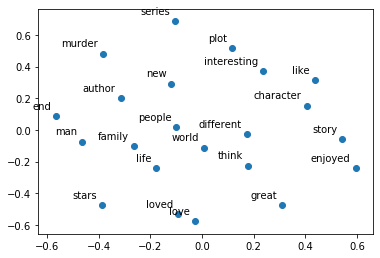

In [101]:
seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(lift_inverse_df)
coords = pos.embedding_


plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(top_fiction_review_words, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-5, 5),
        textcoords = 'offset points', ha = 'right', va = 'bottom')

plt.show()

### MDS plot for Summaries of Fictional Books

In [42]:
lift_inverse_df = 1/lift_df_fic_sum
np.fill_diagonal(lift_inverse_df.values, 0)

print ('Inverse Lift Matrix:\n')
lift_inverse_df = lift_inverse_df.replace(float("inf"),1)
lift_inverse_df

Inverse Lift Matrix:



,man,world,bestselling,woman,murder,life,story,home,author,family,...,death,house,thriller,mother,father,day,police,beautiful,investigation,truth
man,0.000000,0.950000,1.068750,0.900000,0.956250,0.964286,0.964286,0.956250,0.969231,0.975000,...,0.900,1.0125,1.157143,1.0125,1.200000,1.145455,0.900000,0.900000,1.200000,0.900000
world,0.950000,0.000000,1.203333,1.292000,1.292000,1.140000,0.712500,1.292000,1.773333,0.823333,...,0.855,0.8550,3.420000,0.8550,1.013333,1.330000,1.330000,0.665000,3.040000,1.000000
bestselling,1.068750,1.203333,0.000000,3.230000,1.076667,1.425000,1.900000,1.615000,0.483636,0.705714,...,1.140,0.6840,0.570000,1.7100,1.520000,0.886667,0.886667,2.660000,0.760000,1.330000
woman,0.900000,1.292000,3.230000,0.000000,0.963333,0.850000,0.850000,0.825714,1.586667,2.210000,...,3.060,1.5300,1.530000,0.6120,1.360000,0.952000,0.793333,0.793333,0.906667,0.793333
murder,0.956250,1.292000,1.076667,0.963333,0.000000,1.700000,1.275000,0.963333,1.190000,2.210000,...,1.020,1.5300,1.020000,1.5300,0.906667,2.380000,0.476000,2.380000,0.680000,0.793333
life,0.964286,1.140000,1.425000,0.850000,1.700000,0.000000,0.750000,1.020000,0.840000,0.975000,...,0.900,0.9000,2.700000,0.5400,2.400000,0.700000,0.700000,0.700000,1.200000,1.050000
story,0.964286,0.712500,1.900000,0.850000,1.275000,0.750000,0.000000,1.700000,1.050000,0.780000,...,0.900,0.6750,1.000000,0.6750,0.800000,0.600000,2.100000,0.420000,1.200000,1.050000
home,0.956250,1.292000,1.615000,0.825714,0.963333,1.020000,1.700000,0.000000,4.760000,0.631429,...,1.020,1.0200,0.765000,0.6120,0.906667,0.952000,2.380000,0.595000,1.360000,0.476000
author,0.969231,1.773333,0.483636,1.586667,1.190000,0.840000,1.050000,4.760000,0.000000,0.910000,...,0.840,0.5040,0.630000,1.2600,1.120000,0.784000,0.980000,1.960000,0.746667,1.960000
family,0.975000,0.823333,0.705714,2.210000,2.210000,0.975000,0.780000,0.631429,0.910000,0.000000,...,0.468,0.5850,0.780000,0.3900,0.520000,0.910000,1.820000,1.820000,1.000000,0.606667


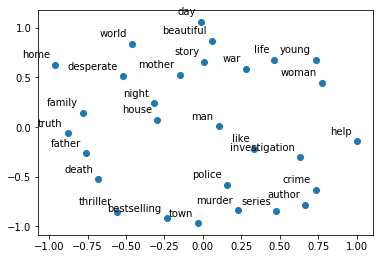

In [43]:
seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(lift_inverse_df)
coords = pos.embedding_


plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(top_fiction_summary_words, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-5, 5),
        textcoords = 'offset points', ha = 'right', va = 'bottom')

plt.show()

### MDS plot for Reviews of Non-Fictional Books

In [102]:
lift_inverse_df = 1/lift_df_nonfic_rev
np.fill_diagonal(lift_inverse_df.values, 0)

print ('Inverse Lift Matrix:\n')
lift_inverse_df = lift_inverse_df.replace(float("inf"),1)
lift_inverse_df

Inverse Lift Matrix:



,people,time,life,trump,think,great,history,interesting,story,president,...,work,love,america,right,country,man,politics,author,white,personal
people,0.000000,0.633218,0.619966,0.679473,0.585746,0.706189,0.651070,0.728466,0.679777,0.640212,...,0.556179,0.721318,0.577770,0.529522,0.495095,0.628746,0.589750,0.666263,0.548406,0.551892
time,0.633218,0.000000,0.644398,0.768422,0.648349,0.733611,0.661974,0.782275,0.686372,0.672449,...,0.641742,0.725649,0.668883,0.583111,0.606774,0.683076,0.651812,0.682761,0.574722,0.625363
life,0.619966,0.644398,0.000000,1.111365,0.647208,0.704789,0.827138,0.799983,0.657932,0.825218,...,0.605125,0.567562,0.795571,0.664997,0.697871,0.651313,0.720201,0.743555,0.656855,0.487533
trump,0.679473,0.768422,1.111365,0.000000,0.748469,0.881145,0.899557,0.798627,0.918876,0.385820,...,0.637736,1.197730,0.578149,0.549189,0.512301,0.769231,0.497801,0.726468,0.358070,0.670336
think,0.585746,0.648349,0.647208,0.748469,0.000000,0.725534,0.723824,0.735397,0.717617,0.718545,...,0.605665,0.701513,0.711821,0.556803,0.617028,0.684709,0.635596,0.660285,0.604585,0.587751
great,0.706189,0.733611,0.704789,0.881145,0.725534,0.000000,0.634580,0.903463,0.704953,0.673215,...,0.688616,0.728124,0.630916,0.644087,0.599020,0.764487,0.652161,0.781351,0.685074,0.658306
history,0.651070,0.661974,0.827138,0.899557,0.723824,0.634580,0.000000,0.689734,0.293674,0.692330,...,0.694649,1.021839,0.477797,0.501993,0.543470,0.690141,0.638611,0.617068,0.671443,0.638737
interesting,0.728466,0.782275,0.799983,0.798627,0.735397,0.903463,0.689734,0.000000,0.725475,0.910737,...,0.747823,0.909715,0.838849,0.774135,0.841532,0.827543,0.730046,0.776850,0.737743,0.741838
story,0.679777,0.686372,0.657932,0.918876,0.717617,0.704953,0.293674,0.725475,0.000000,0.754881,...,0.679133,0.786849,0.603495,0.602480,0.656234,0.697291,0.666252,0.679120,0.681960,0.624687
president,0.640212,0.672449,0.825218,0.385820,0.718545,0.673215,0.692330,0.910737,0.754881,0.000000,...,0.569543,0.952952,0.471346,0.502098,0.390583,0.671861,0.458639,0.682987,0.352383,0.559913


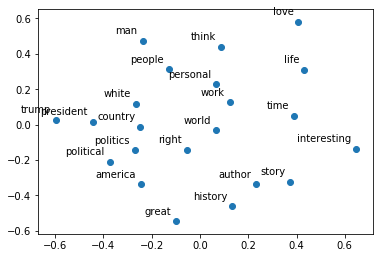

In [103]:
seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(lift_inverse_df)
coords = pos.embedding_


plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(top_nonfiction_review_words, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-5, 5),
        textcoords = 'offset points', ha = 'right', va = 'bottom')

plt.show()

### MDS plot for Summaries of Non-Fictional Books

In [45]:
lift_inverse_df = 1/lift_df_nonfic_sum
np.fill_diagonal(lift_inverse_df.values, 0)

print ('Inverse Lift Matrix:\n')
lift_inverse_df = lift_inverse_df.replace(float("inf"),1)
lift_inverse_df

Inverse Lift Matrix:



,america,life,president,world,story,history,trump,personal,like,people,...,obama,office,human,democracy,great,nation,bestselling,house,news,clinton
america,0.000000,1.338182,0.808421,0.896000,0.853333,0.810667,0.868571,1.137778,1.047273,1.280000,...,0.914286,0.960,0.853333,0.853333,0.832000,0.817778,0.960000,1.152000,0.853333,0.896000
life,1.338182,0.000000,1.380000,0.878182,1.170909,1.248571,1.456667,0.613333,0.920000,0.805000,...,1.533333,1.380,0.920000,1.226667,1.196000,1.058000,4.140000,1.035000,1.840000,1.610000
president,0.808421,1.380000,0.000000,1.260000,0.840000,0.760000,0.506667,1.097143,0.864000,1.344000,...,0.533333,0.720,1.280000,0.548571,1.040000,0.736000,1.440000,0.720000,0.768000,0.480000
world,0.896000,0.878182,1.260000,0.000000,0.904615,0.725455,1.330000,1.344000,0.945000,0.980000,...,1.050000,0.945,0.672000,1.120000,0.910000,0.805000,1.890000,0.756000,1.120000,2.940000
story,0.853333,1.170909,0.840000,0.904615,0.000000,0.560000,0.818462,0.995556,1.008000,1.120000,...,0.933333,1.008,0.896000,0.896000,0.910000,0.805000,1.680000,0.840000,1.120000,0.653333
history,0.810667,1.248571,0.760000,0.725455,0.560000,0.000000,0.722000,1.216000,0.977143,1.330000,...,0.950000,0.855,1.013333,1.013333,0.823333,0.728333,1.140000,0.855000,1.520000,0.665000
trump,0.868571,1.456667,0.506667,1.330000,0.818462,0.722000,0.000000,1.013333,0.760000,0.886667,...,0.475000,0.570,1.520000,0.608000,0.988000,0.794545,1.710000,0.488571,0.760000,0.443333
personal,1.137778,0.613333,1.097143,1.344000,0.995556,1.216000,1.013333,0.000000,0.960000,0.746667,...,0.800000,1.440,0.640000,0.512000,4.160000,1.051429,0.960000,0.720000,1.280000,0.746667
like,1.047273,0.920000,0.864000,0.945000,1.008000,0.977143,0.760000,0.960000,0.000000,1.008000,...,0.900000,1.080,1.440000,0.720000,0.936000,0.920000,1.620000,1.080000,0.960000,0.504000
people,1.280000,0.805000,1.344000,0.980000,1.120000,1.330000,0.886667,0.746667,1.008000,0.000000,...,0.933333,0.840,0.746667,1.120000,1.213333,0.920000,1.260000,0.840000,1.120000,1.960000


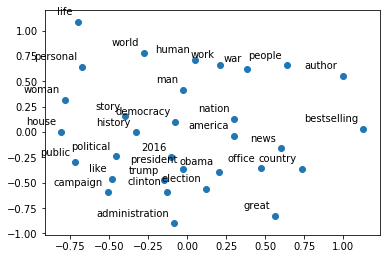

In [46]:
seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(lift_inverse_df)
coords = pos.embedding_


plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(top_nonfiction_summary_words, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-5, 5),
        textcoords = 'offset points', ha = 'right', va = 'bottom')

plt.show()

### Recommender

In [29]:
df_genre=df.copy()
df_genre=df_genre[['Title','Author','Book_ID','Genre','Summary','Summary_Tokens']]
df_genre.drop_duplicates('Title', inplace=True)

def clean_genre(genre):
    genres=list(set(genre.split(' ')))
    
    removal=['Hi...','In']
    ii='II'
    icent='21st'
    for r in removal:
        if r in genres:
            genres.remove(r)
        if ii in genres:
            genres.remove('World')
            genres.remove('War')
            genres.remove(ii)
            genres.append('World War II')
        if icent in genres:
            genres.remove('Century')
            genres.remove(icent)
            genres.append('21st Century')
    return genres

def stringify(tokens):
    return ' '.join(tokens)

df_genre.GenreTokens=df_genre.Genre.apply(clean_genre)
df_genre['Clean_Summary']=df_genre.Summary_Tokens.apply(stringify)

df_fiction=df_genre[df_genre["Book_ID"]<51]
df_nonfiction=df_genre[df_genre["Book_ID"]>50]

In [30]:
allgenres=set()
for i in range(len(df_genre)):
    for x in df_genre.GenreTokens.iloc[i]:
        allgenres.add(x)

### Unique Genres:

21st Century, Adult, Adventure, American, Art, Audiobook, Autobiography, Biography, Biology, Business, Canada, Chick, Civil, Classics, Contemporary, Crime, Cultural, Drama, Dystopia, Economics, Education, Epic, Espionage, Essays, Fantasy, Feminism, Fiction, Health, Help, High, Historical, History, Horror, Humor, Inspirational, Leadership, Legal, Lit, Literature, Love, Magical, Media, Memoir, Military, Music, Mystery, Mythology, Neuroscience, Nonfiction, North, Philosophy, Photography, Physics, Political, Politics, Presidents, Psychology, Realism, Religion, Romance, Romantic, Russia, Science, Self, Short, Sociology, Spirituality, Spy, Star, Stories, Suspense, Thriller, Tie, War, Wars, Westerns, Womens, World War II, Writing, Young

In [20]:
nlp = en_core_web_lg.load()

In [26]:
fthemes=input("Enter genres you want a Fiction book recommendation for: ").lower().split(",")

Enter genres you want a Fiction book recommendation for: fantasy,magic,adventure


### Recommendation based on Similarity with Summary - Fiction

In [31]:
def getSimilaritySummary(df_sim, themes):
    listToStr=' '.join(themes)
    doc1 = nlp(listToStr)
    df_sim["GenSum_Similarity_Score"]=np.nan
    for i, row in df_sim.iterrows():
        doc2 = nlp(row["Clean_Summary"])
        doc3 = nlp(row["Genre"])
        summ=doc1.similarity(doc2)
        gen=doc1.similarity(doc3)
        df_sim.loc[i,"GenSum_Similarity_Score"] = round(summ,4)
        
    return df_sim

In [32]:
import warnings
warnings.simplefilter("ignore")
df_fiction=getSimilaritySummary(df_fiction, fthemes)
df_fiction=df_fiction.sort_values('GenSum_Similarity_Score', ascending=False)
df_fiction[['Title','Author','GenSum_Similarity_Score']].head()

,Title,Author,GenSum_Similarity_Score
15290,Fire & Blood,George R.R. Martin,0.6339
6580,The Rising Sea,Clive Cussler,0.6211
9099,The Cast,Danielle Steel,0.6198
7813,Circe,Madeline Miller,0.6186
9757,The President Is Missing,Bill Clinton,0.6115


### Recommendation based on Similarity with Summary - NonFiction

In [33]:
nfthemes=input("Enter genres you want a Nonfiction recommendation for: ").lower().split(",")

Enter genres you want a Nonfiction recommendation for: personal,president,trump


In [34]:
df_nonfiction=getSimilaritySummary(df_nonfiction, nfthemes)
df_nonfiction=df_nonfiction.sort_values('GenSum_Similarity_Score', ascending=False)
df_nonfiction[['Title','Author','GenSum_Similarity_Score']].head()

,Title,Author,GenSum_Similarity_Score
22389,"A Higher Loyalty: Truth, Lies, and Leadership",James Comey,0.7760
24586,The Russia Hoax: The Illicit Scheme to Clear H...,Gregg Jarrett,0.7438
26507,Shade: A Tale of Two Presidents,Pete Souza,0.7419
16277,The Threat: How the FBI Protects America in th...,Andrew G. McCabe,0.7378
29893,Understanding Trump,Newt Gingrich,0.7350


## Recommendation based on Similarity with Reviews - Fiction

In [38]:
df_review=df[['Title','Author','Book_ID','Genre','Review_Tokens','User_Review']]

def docify_review(review):
    reviews=' '.join(review)
    return reviews

df_review['Doc_Review']=df_review.Review_Tokens.apply(docify_review)
df_fiction=df_review[df_review["Book_ID"]<51]
df_nonfiction=df_review[df_review["Book_ID"]>50]

In [39]:
def getSimilarityReview(df_sim, themes):
    listToStr=' '.join(themes)
    doc1 = nlp(listToStr)
    df_sim["GenRev_Similarity_Score"]=np.nan
    for i, row in df_sim.iterrows():
        doc2 = nlp(row["Doc_Review"])
        doc3 = nlp(row["Genre"])
        rev=doc1.similarity(doc2)
        gen=doc1.similarity(doc3)
        df_sim.loc[i,"GenRev_Similarity_Score"] = round(rev,2)

    return df_sim

def getBookRecommendations(df_sim):
    df_sim = df_sim.groupby(['Title','Author','Book_ID','Genre'])['GenRev_Similarity_Score'].mean()
    df_sim = df_sim.reset_index()
    df_sim.columns = np.where(df_sim.columns==0, 'GenRev_Similarity_Score', df_sim.columns)
    return df_sim

### Sentiment Analysis of Reviews of Fictional Books

In [42]:
df_fiction=getSimilarityReview(df_fiction, fthemes)
df_fiction=df_fiction.sort_values('GenRev_Similarity_Score', ascending=False)
df_ff=df_fiction[['Book_ID','Title','Author','GenRev_Similarity_Score','User_Review']].head(5000)


In [43]:
df_ff = pd.read_csv("top5000_similarreviews_fiction.csv")

In [45]:
pair_list = lift_df_fic_rev[(lift_df_fic_rev.index == "story") | (lift_df_fic_rev.index == "book")].stack().index.tolist()
sorted_lifts = []
for index,column in pair_list:
    sorted_lifts.append(((index,column),lift_df_fic_rev[index][column]))

df_test = df_ff.copy()

cols = ["Book_ID"]
for i in sorted_lifts:
    types = i[0][0]
    style = i[0][1]
    key = (style,types)
    cols.append(key)

df_new = pd.DataFrame(columns = cols)

sorted_lifts_nt = []
sentiment_dict = {}
    
def sentiment_value(review):
    analyser = sentiment()
    result = analyser.polarity_scores(review)
    score = result['compound']
    return round(score,1)

count=0

for j in range(1,51):
    for i in sorted_lifts:
        types = i[0][0]
        style = i[0][1]
        key = (style,types)
        sentiments = []
        for review in df_test[df_test["Book_ID"]==j]["User_Review"]:
            if types in review and style in review:
                words = re.findall(r'\w+', review)
                if types in words:
                    index = words.index(types)
                    left = words[index - 10:index]
                    right = words[index + 1:index + 11]
                    tweetyy = " ".join(left) + " " + words[index] + " " + " ".join(right)
                else:
                    tweetyy = review
    #             print(tweetyy, sv)
                sv = sentiment_value(tweetyy)
                sentiments.append(sv)
    #     print(sentiments)
    #     print(i)
        if len(sentiments)>0:
            avg_sentiment = round(sum(sentiments)/len(sentiments),2)
        else:
            avg_sentiment = 0
        sentiment_dict[key] = avg_sentiment
    
    
    df_new.loc[len(df_new)] = [j] + list(sentiment_dict.values())
print("Style  Types sentiment")
df_new

Style  Types sentiment


,Book_ID,"(character, story)","(like, story)","(series, story)","(love, story)","(great, story)","(end, story)","(new, story)","(think, story)","(people, story)",...,"(stars, story)","(author, story)","(enjoyed, story)","(loved, story)","(interesting, story)","(world, story)","(murder, story)","(family, story)","(man, story)","(different, story)"
0,1.0,0.52,0.00,0.60,0.55,0.60,0.43,0.70,0.00,0.32,...,0.00,0.00,0.60,0.80,0.00,0.00,0.00,0.00,0.42,0.60
1,2.0,0.24,0.26,0.00,0.25,0.28,0.20,0.21,0.21,0.22,...,0.25,0.24,0.02,0.30,0.28,0.24,0.09,0.01,0.14,0.30
2,3.0,0.40,0.52,0.11,0.80,0.37,0.13,-0.33,0.00,0.00,...,0.80,0.55,0.05,0.80,0.80,0.00,0.06,0.00,-0.05,0.00
3,4.0,0.08,0.16,0.75,0.16,0.33,0.19,0.07,0.21,0.16,...,0.02,0.18,0.48,0.24,0.17,0.24,0.00,-0.01,0.17,0.29
4,5.0,0.25,0.18,-0.05,0.32,0.13,0.16,0.25,0.23,0.07,...,0.28,0.12,0.20,0.33,0.33,0.04,0.29,-0.20,0.09,-0.06
5,6.0,0.36,0.28,0.34,0.29,0.34,0.20,0.18,0.32,0.04,...,0.14,0.22,0.28,0.21,0.17,0.33,0.00,0.24,0.30,0.35
6,7.0,0.06,0.22,-0.02,0.00,0.20,0.12,-0.16,0.06,0.23,...,-0.70,0.26,0.40,-0.13,-0.15,0.00,-0.26,0.00,0.03,0.40
7,8.0,0.19,0.18,0.19,0.12,0.31,0.16,-0.05,0.04,0.51,...,0.27,0.18,0.12,-0.07,0.10,0.20,0.00,0.47,0.14,0.34
8,9.0,0.32,0.17,-0.20,0.33,0.66,0.23,0.20,0.24,0.35,...,0.44,0.35,0.52,0.38,0.17,-0.15,0.00,0.50,0.20,0.09
9,10.0,0.40,0.31,0.30,0.33,0.35,0.45,0.46,0.53,0.70,...,0.47,0.48,0.52,0.53,0.65,-0.06,0.00,0.15,0.30,0.25


In [91]:
df_new = df_new.sort_values(by=[('family', 'story')],axis=0,ascending=False)

In [92]:
df_new

,Book_ID,"(character, story)","(like, story)","(series, story)","(love, story)","(great, story)","(end, story)","(new, story)","(think, story)","(people, story)",...,"(stars, story)","(author, story)","(enjoyed, story)","(loved, story)","(interesting, story)","(world, story)","(murder, story)","(family, story)","(man, story)","(different, story)"
33,34.0,0.32,0.46,0.90,0.34,0.55,0.32,0.46,0.49,0.31,...,0.35,0.46,0.45,0.29,0.50,0.10,-0.70,0.70,0.35,0.25
34,35.0,0.27,0.37,0.43,0.60,0.79,0.25,0.07,-0.08,-0.75,...,-0.10,0.24,0.83,0.60,-0.60,0.40,0.35,0.60,0.27,0.64
46,47.0,0.29,0.53,0.39,0.50,0.75,0.53,0.45,0.22,0.50,...,0.34,-0.20,0.51,0.67,0.40,-0.20,0.00,0.57,0.53,0.60
28,29.0,0.43,0.50,0.50,0.60,0.63,0.53,0.68,0.16,0.30,...,0.66,0.45,0.64,0.53,0.53,0.48,0.00,0.54,0.49,0.46
42,43.0,0.53,0.55,0.00,0.54,0.57,0.52,0.63,0.65,0.57,...,0.49,0.53,0.70,0.54,0.35,0.47,0.00,0.54,0.58,0.66
44,45.0,0.29,0.26,0.35,0.35,0.36,0.27,0.19,0.27,0.09,...,0.36,0.22,0.26,0.11,0.38,0.18,0.00,0.52,0.17,0.24
8,9.0,0.32,0.17,-0.20,0.33,0.66,0.23,0.20,0.24,0.35,...,0.44,0.35,0.52,0.38,0.17,-0.15,0.00,0.50,0.20,0.09
7,8.0,0.19,0.18,0.19,0.12,0.31,0.16,-0.05,0.04,0.51,...,0.27,0.18,0.12,-0.07,0.10,0.20,0.00,0.47,0.14,0.34
25,26.0,0.45,0.57,0.36,0.04,0.81,0.21,0.33,0.47,0.25,...,0.83,0.30,0.29,0.07,-0.00,0.00,0.56,0.47,0.25,0.18
47,48.0,0.20,0.40,0.28,0.49,0.49,0.32,0.12,0.35,0.45,...,0.52,0.36,0.49,0.53,0.27,0.45,-0.45,0.42,0.36,0.23


In [70]:
df_new.to_csv("SentimentforFictionalBooks.csv", index=False)

In [189]:
df_ff.to_csv('top5000_similarreviews_fiction.csv', index=False)

In [199]:
print("Recommended books for themes:"," ".join(fthemes))
df_f_reco=getBookRecommendations(df_fiction)
df_f_reco.head()

Recommended books for themes: fantasy magic adventure


,Title,Author,Book_ID,Genre,GenRev_Similarity_Score
0,A Better Man,Louise Penny,15,Mystery Fiction Audiobook Cultural Canada,0.541611
1,A Spark of Light,Jodi Picoult,41,Fiction Contemporary,0.520395
2,Accidental Heroes,Danielle Steel,22,Fiction Romance,0.544833
3,An Absolutely Remarkable Thing,Hank Green,40,Fiction Science Fiction Young Adult Contemporary,0.550061
4,An Anonymous Girl,Greer Hendricks,9,Thriller Mystery Fiction Thriller Mystery Thri...,0.566383


## Recommendation based on Similarity with Reviews - NonFiction

In [190]:
df_nonfiction=getSimilarityReview(df_nonfiction, nfthemes)
df_nonfiction=df_nonfiction.sort_values('GenRev_Similarity_Score', ascending=False)
df_nff=df_nonfiction[['Book_ID','Title','Author','GenRev_Similarity_Score','User_Review']].head(5000)

In [51]:
df_nff = pd.read_csv("top5000_similarreviews_nonfiction.csv")

### Sentiment Analysis of Reviews of Non-Fictional Books

In [52]:
pair_list = lift_df_fic_rev[(lift_df_fic_rev.index == "story")| (lift_df_fic_rev.index == "book")].stack().index.tolist()
sorted_lifts = []
for index,column in pair_list:
    sorted_lifts.append(((index,column),lift_df_fic_rev[index][column]))

df_test = df_nff.copy()

cols = ["Book_ID"]
for i in sorted_lifts:
    types = i[0][0]
    style = i[0][1]
    key = (style,types)
    cols.append(key)

df_new1 = pd.DataFrame(columns = cols)

sorted_lifts_nt = []
sentiment_dict = {}
    
def sentiment_value(review):
    analyser = sentiment()
    result = analyser.polarity_scores(review)
    score = result['compound']
    return round(score,1)

count=0

for j in range(51,101):
    for i in sorted_lifts:
        types = i[0][0]
        style = i[0][1]
        key = (style,types)
        sentiments = []
        for review in df_test[df_test["Book_ID"]==j]["User_Review"]:
            if types in review and style in review:
                words = re.findall(r'\w+', review)
                if types in words:
                    index = words.index(types)
                    left = words[index - 10:index]
                    right = words[index + 1:index + 11]
                    tweetyy = " ".join(left) + " " + words[index] + " " + " ".join(right)
                else:
                    tweetyy = review
    #             print(tweetyy, sv)
                sv = sentiment_value(tweetyy)
                sentiments.append(sv)
    #     print(sentiments)
    #     print(i)
        if len(sentiments)>0:
            avg_sentiment = round(sum(sentiments)/len(sentiments),2)
        else:
            avg_sentiment = 0
        sentiment_dict[key] = avg_sentiment
    
    
    df_new1.loc[len(df_new1)] = [j] + list(sentiment_dict.values())
print("Style  Types sentiment")
df_new1.head()

Style  Types sentiment


,Book_ID,"(character, story)","(like, story)","(series, story)","(love, story)","(great, story)","(end, story)","(new, story)","(think, story)","(people, story)",...,"(stars, story)","(author, story)","(enjoyed, story)","(loved, story)","(interesting, story)","(world, story)","(murder, story)","(family, story)","(man, story)","(different, story)"
0,51.0,0.10,0.35,1.00,0.12,0.47,0.33,0.32,0.28,0.30,...,0.53,0.20,0.55,0.00,0.23,0.48,0.0,0.53,0.14,0.36
1,52.0,0.20,0.86,0.00,0.94,0.76,0.74,0.69,0.65,0.80,...,0.93,0.74,0.97,0.95,0.69,0.69,0.5,0.90,0.71,0.10
2,53.0,0.00,-0.17,0.00,-0.60,-0.60,-0.75,0.00,-0.60,-0.75,...,0.00,0.00,1.00,0.00,-0.90,-0.60,0.0,-0.75,-0.17,0.00
3,54.0,0.48,0.43,0.15,0.52,0.43,0.52,0.42,0.43,0.49,...,0.70,0.53,1.00,0.30,0.39,0.52,0.0,0.56,0.51,0.38
4,55.0,0.45,0.37,0.50,0.41,0.45,0.34,0.29,0.44,0.29,...,0.50,0.41,0.33,0.30,0.30,0.20,0.7,0.00,0.37,0.51


In [107]:
df_new1 = df_new1.sort_values(by=[('interesting', 'story')],axis=0,ascending=False)

In [108]:
df_new1.head(5)

,Book_ID,"(character, story)","(like, story)","(series, story)","(love, story)","(great, story)","(end, story)","(new, story)","(think, story)","(people, story)",...,"(stars, story)","(author, story)","(enjoyed, story)","(loved, story)","(interesting, story)","(world, story)","(murder, story)","(family, story)","(man, story)","(different, story)"
40,91.0,-0.1,0.43,1.0,0.69,0.45,0.42,0.24,0.31,0.45,...,0.25,0.62,0.35,0.65,0.93,0.36,0.0,0.31,0.52,1.0
46,97.0,0.0,0.82,1.0,1.00,1.00,0.87,0.00,0.98,0.99,...,0.90,0.97,0.00,0.00,0.90,0.96,0.0,0.00,0.99,0.0
45,96.0,0.8,0.15,0.0,1.00,0.98,0.62,0.73,0.48,0.48,...,1.00,0.07,1.00,0.00,0.88,0.30,-0.7,0.30,0.60,0.0
26,77.0,0.0,0.65,0.0,0.38,0.52,0.49,0.44,1.00,1.00,...,0.00,0.33,0.00,-1.00,0.70,0.00,0.0,0.20,0.40,-1.0
1,52.0,0.2,0.86,0.0,0.94,0.76,0.74,0.69,0.65,0.80,...,0.93,0.74,0.97,0.95,0.69,0.69,0.5,0.90,0.71,0.1


In [72]:
df_new1.to_csv("SentimentforNonFictionalBooks.csv", index=False)

In [191]:
df_nff.to_csv('top5000_similarreviews_nonfiction.csv', index=False)

In [200]:
print("Recommended books for themes:"," ".join(nfthemes))
df_nf_reco=getBookRecommendations(df_nonfiction)
df_nf_reco.head()

Recommended books for themes: personal president trump


,Title,Author,Book_ID,Genre,GenRev_Similarity_Score
0,21 Lessons for the 21st Century,Yuval Noah Harari,80,Nonfiction History Philosophy Science Politics,0.589666
1,"A Higher Loyalty: Truth, Lies, and Leadership",James Comey,71,Nonfiction Politics Autobiography Memoir Biogr...,0.655866
2,"Al Franken, Giant of the Senate",Al Franken,94,Nonfiction Politics Autobiography Memoir Biogr...,0.634286
3,Astrophysics for People in a Hurry,Neil deGrasse Tyson,93,Nonfiction Science Audiobook Science Physics,0.547082
4,Beastie Boys Book,Michael Diamond,85,Music Nonfiction Biography Autobiography Memoi...,0.531854


## Recommendation based on Sentiment of Reviews - Fiction

In [178]:
fiction=fthemes#fiction
nonfiction=nfthemes #nonfiction

fpair_list=[]
for i in lift_df_fic_rev.index:
    for j in lift_df_fic_rev.index:
        if i!=j and (j in fiction) and (i in fiction) and (j,i) not in fpair_list:
                fpair_list.append((i,j))

nfpair_list=[]
for i in lift_df_nonfic_rev.index:
    for j in lift_df_nonfic_rev.index:
        if i!=j and (j in nonfiction) and (i in nonfiction) and (j,i) not in nfpair_list:
            nfpair_list.append((i,j))
            

In [179]:
df_test = df[df["Book_ID"]<51]

cols = ["Book_ID"]
for i in fiction:
    cols.append(i)
cols.append('Combined')

df_new = pd.DataFrame(columns = cols)

sorted_lifts_nt = []
sentiment_dict = {}
    
def sentiment_value(review):
    analyser = sentiment()
    result = analyser.polarity_scores(review)
    score = result['compound']
    return round(score,1)

count=0

for j in range(1,51):
    for i in fiction:
        key = i
        sentiments = []
        for review in df_test[df_test["Book_ID"]==j]["User_Review"]:
            if key in review:
                words = re.findall(r'\w+', review)
                if key in words:
                    index = words.index(key)
                    left = words[index - 10:index]
                    right = words[index + 1:index + 11]
                    tweetyy = " ".join(left) + " " + words[index] + " " + " ".join(right)
                else:
                    tweetyy = review
                sv = sentiment_value(tweetyy)
                sentiments.append(sv)
        if len(sentiments)>0:
            avg_sentiment = round(sum(sentiments)/len(sentiments),2)
        else:
            avg_sentiment = 0
        sentiment_dict[key] = avg_sentiment
        sentiment_dict['Combined'] = round(sum(sentiments),2)
    
    df_new.loc[len(df_new)] = [j] + list(sentiment_dict.values())

df_new.sort_values('Combined', ascending=False).head()

,Book_ID,fantasy,magic,adventure,Combined
17,18.0,0.65,2.0,0.00,1.00
28,29.0,0.05,1.9,1.00,0.95
34,35.0,0.00,1.7,0.00,0.85
42,43.0,0.70,1.6,0.77,0.80
37,38.0,0.00,0.8,0.60,0.80


In [180]:
df_reco_fc=pd.merge(df_fiction[['Book_ID','Title','Author','GenRev_Similarity_Score']], df_new, on='Book_ID', how='left')
df_reco_fc.drop_duplicates(['Book_ID','Title','Author'],inplace=True)
df_reco_fc=df_reco_fc[['Book_ID','Title','Author','Combined','GenRev_Similarity_Score']]
df_reco_fc.sort_values('Combined', ascending=False).head()

,Book_ID,Title,Author,Combined,GenRev_Similarity_Score
16,18,The Woman in the Window,A.J. Finn,1.00,0.560152
45,29,The Cast,Danielle Steel,0.95,0.540669
28,35,Texas Ranger,James Patterson,0.85,0.551489
46,38,Juror #3,James Patterson,0.80,0.539909
15,43,Every Breath,Nicholas Sparks,0.80,0.560268


## Recommendation based on Sentiment of Reviews - NonFiction

In [181]:
df_test = df[df["Book_ID"]>50]

cols = ["Book_ID"]
for i in nonfiction:
    cols.append(i)
cols.append('Combined')

df_new1 = pd.DataFrame(columns = cols)

sorted_lifts_nt = []
sentiment_dict = {}
    
def sentiment_value(review):
    analyser = sentiment()
    result = analyser.polarity_scores(review)
    score = result['compound']
    return round(score,1)

count=0

for j in range(51,101):
    for i in nonfiction:
        key = i
        sentiments = []
        for review in df_test[df_test["Book_ID"]==j]["User_Review"]:
            if key in review:
                words = re.findall(r'\w+', review)
                if key in words:
                    index = words.index(key)
                    left = words[index - 10:index]
                    right = words[index + 1:index + 11]
                    tweetyy = " ".join(left) + " " + words[index] + " " + " ".join(right)
                else:
                    tweetyy = review
                sv = sentiment_value(tweetyy)
                sentiments.append(sv)
        if len(sentiments)>0:
            avg_sentiment = round(sum(sentiments)/len(sentiments),2)
        else:
            avg_sentiment = 0
        sentiment_dict[key] = avg_sentiment
        sentiment_dict['Combined'] = round(sum(sentiments),2)
    
    
    df_new1.loc[len(df_new1)] = [j] + list(sentiment_dict.values())

df_new1.sort_values('Combined', ascending=False).head()

,Book_ID,personal,president,trump,Combined
46,97.0,0.87,2.0,0.28,1.00
41,92.0,0.01,1.0,0.00,1.00
37,88.0,0.56,0.4,0.39,0.40
25,76.0,0.49,27.7,0.40,0.31
3,54.0,0.28,2.3,0.00,0.26


In [182]:
df_reco_nonfc=pd.merge(df_nonfiction[['Book_ID','Title','Author','GenRev_Similarity_Score']], df_new1, on='Book_ID', how='left')
df_reco_nonfc.drop_duplicates(['Book_ID','Title','Author'],inplace=True)
df_reco_nonfc=df_reco_nonfc[['Book_ID','Title','Author','Combined','GenRev_Similarity_Score']]
df_reco_nonfc.sort_values('GenRev_Similarity_Score', ascending=False).sort_values('Combined', ascending=False).head()

,Book_ID,Title,Author,Combined,GenRev_Similarity_Score
35,97,Rediscovering Americanism: And the Tyranny of ...,Mark R. Levin,1.00,0.581953
27,92,"Option B: Facing Adversity, Building Resilienc...",Sheryl Sandberg,1.00,0.600970
31,88,Portraits of Courage: A Commander in Chief's T...,George W. Bush,0.40,0.598933
8,76,Yes We (Still) Can: Politics in the Age of Oba...,Dan Pfeiffer,0.31,0.635137
23,54,The Second Mountain,David Brooks,0.26,0.604924


## Naïve Recommendation based on Avg Rating

In [220]:
df_rating=df.copy()
df_rating=df_rating[['Title','Author','Book_ID','Genre','Summary','Summary_Tokens','Overall_Rating']]
df_rating.drop_duplicates('Title', inplace=True)
df_f_avg=df_rating[df_rating["Book_ID"]<51]
df_nf_avg=df_rating[df_rating["Book_ID"]>50]

In [203]:
def getSimilarGenre(df_sim, themes):
    listToStr=' '.join(themes)
    doc1 = nlp(listToStr)
    df_sim["Gen_Similarity_Score"]=np.nan
    for i, row in df_sim.iterrows():
        doc3 = nlp(row["Genre"])
        gen=doc1.similarity(doc3)
        df_sim.loc[i,"Gen_Similarity_Score"] = round(gen,2)

    return df_sim

In [221]:
print("Recommended books for themes:"," ".join(fthemes))
df_f_avg=getSimilarGenre(df_f_avg, fthemes)
df_f_avg=df_f_avg.sort_values('Gen_Similarity_Score', ascending=False)
df_f_avg=df_f_avg[['Book_ID','Title','Author','Gen_Similarity_Score','Overall_Rating']]
df_f_avg['Combined_Score']=df_f_avg['Gen_Similarity_Score']+df_f_avg['Overall_Rating']
df_f_avg=df_f_avg.sort_values('Combined_Score', ascending=False)
df_f_avg.head(5)

Recommended books for themes: fantasy magic adventure


,Book_ID,Title,Author,Gen_Similarity_Score,Overall_Rating,Combined_Score
15619,49,Oathbringer,Brandon Sanderson,0.86,4.62,5.48
329,2,Where the Crawdads Sing,Delia Owens,0.65,4.50,5.15
1974,7,The Night Fire,Michael Connelly,0.67,4.41,5.08
4606,15,A Better Man,Louise Penny,0.67,4.39,5.06
11701,37,Leverage in Death,J.D. Robb,0.70,4.35,5.05


In [222]:
print("Recommended books for themes:"," ".join(nfthemes))
df_nf_avg=getSimilarGenre(df_nf_avg, nfthemes)
df_nf_avg=df_nf_avg.sort_values('Gen_Similarity_Score', ascending=False)
df_nf_avg=df_nf_avg[['Book_ID','Title','Author','Gen_Similarity_Score','Overall_Rating']]
df_nf_avg['Combined_Score']=df_nf_avg['Gen_Similarity_Score']+df_nf_avg['Overall_Rating']
df_nf_avg=df_nf_avg.sort_values('Combined_Score', ascending=False)
df_nf_avg.head(5)


Recommended books for themes: personal president trump


,Book_ID,Title,Author,Gen_Similarity_Score,Overall_Rating,Combined_Score
20744,66,Grant,Ron Chernow,0.63,4.54,5.17
18804,59,Call Sign Chaos: Learning to Lead,Jim Mattis,0.58,4.43,5.01
19752,62,"Blowout: Corrupted Democracy, Rogue State Russ...",Rachel Maddow,0.51,4.45,4.96
24586,78,The Russia Hoax: The Illicit Scheme to Clear H...,Gregg Jarrett,0.55,4.39,4.94
26836,85,Beastie Boys Book,Michael Diamond,0.35,4.56,4.91
